In [36]:
#custom neural networkx models
import neural_networks as ann
#other imports
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

# Load model and autoencoder

That were trained on different script

In [9]:
#main model
conv_net = ann.ConvNet()
extra_layer = ann.Extra_layer()
model = nn.Sequential(conv_net, extra_layer)
model.load_state_dict(torch.load('model_checkpoint.pth'))
model.eval() 

#autoencoder
autoencoder = ann.Autoencoder()
autoencoder.load_state_dict(torch.load('autoencoder_checkpoint.pth'))
autoencoder.eval() 

Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

# Load data

In [12]:
# Specify the target digit for binary classification
batch_size_train = 64
batch_size_test = 1000
target_digit = 8
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
# Create binary classification train and test loaders
binary_train_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=True, transform=transform, target_digit=target_digit),
                          batch_size=batch_size_train, shuffle=True)
binary_test_loader = DataLoader(ann.BinaryMNIST('mnist_data/', train=False, transform=transform, target_digit=target_digit),
                         batch_size=batch_size_test, shuffle=True)

# CROCO

Starting with croco exploration on the MNIST dataset

In [59]:
#import custom implementation of Croco
import gator
from importlib import reload
gator = reload(gator)

In [60]:
PARAMS = {
        "n_samples" : 500,
        "lr": 0.01,
        "t" : 0.5, 
        "m" : 0.1,
        "n_iter": 1000,
        "sigma2" : 50,#0.01 
        "robustness_target" : 0.01, #0.3
        "robustness_epsilon" : 0.01,
        "distribution" : "gaussian"
    }

In [61]:
data_iter = enumerate(binary_test_loader)
batch_idx, (data, targets) = next(data_iter)
eights = (targets==1).nonzero()
x = data[eights[0]]

In [62]:
x_new,hist = gator.croco(
                        model=model,
                        autoencoder=autoencoder,
                        delta=np.zeros(x.shape),
                        x=x.numpy(),
                        weights = [0,1,0], #robustness, validity, proximity
                        n_samples = PARAMS["n_samples"],
                        lr=PARAMS["lr"],
                        sigma2 = PARAMS["sigma2"],
                        robustness_target = PARAMS["robustness_target"],
                        robustness_epsilon = PARAMS["robustness_epsilon"],
                        n_iter=PARAMS["n_iter"],
                        t = PARAMS["t"],
                        m = PARAMS["m"]
                    )

/home/leitao/Projects/MIX_MixedNotes/XAI/xai_proj_8/gator.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_target_class = torch.tensor([0,1]).float().to(device)


NameError: name 'pred_class' is not defined

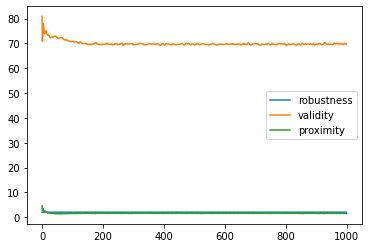

In [56]:
plt.plot(hist["robustness"],label="robustness")
plt.plot(hist["validity"],label="validity")
plt.plot(hist["proximity"],label="proximity")
#plt.plot(hist["loss"],label="loss")
plt.legend()
plt.show()

In [57]:
hist["validity"]

[80.93898010253906,
 70.86971282958984,
 72.8063735961914,
 76.80859375,
 77.9612808227539,
 77.20178985595703,
 75.61205291748047,
 74.4692153930664,
 73.92854309082031,
 73.90496826171875,
 74.17759704589844,
 74.62010955810547,
 74.99115753173828,
 75.0679931640625,
 74.8515396118164,
 74.30865478515625,
 73.8173599243164,
 73.49295806884766,
 73.34830474853516,
 73.35398864746094,
 73.46247100830078,
 73.4700698852539,
 73.34270477294922,
 73.15692901611328,
 72.90790557861328,
 72.61710357666016,
 72.4271469116211,
 72.28227996826172,
 72.29290771484375,
 72.38872528076172,
 72.49684143066406,
 72.50861358642578,
 72.56974029541016,
 72.53883361816406,
 72.52549743652344,
 72.56866455078125,
 72.59339904785156,
 72.6207275390625,
 72.62039184570312,
 72.7433853149414,
 72.86773681640625,
 72.89198303222656,
 72.95025634765625,
 72.97566223144531,
 72.99089813232422,
 72.97579193115234,
 72.8853988647461,
 72.67179107666016,
 72.4796142578125,
 72.340576171875,
 72.26325225830078,


([], [])

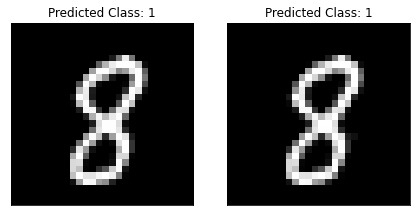

In [58]:
fig = plt.figure()
plt.subplot(1,2,1)
plt.tight_layout()
plt.imshow(x.view(28, 28), cmap='gray', interpolation='none')
predicted_class = torch.argmax(model(x), dim=1).item()
plt.title(f"Predicted Class: {predicted_class}")
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.tight_layout()
plt.imshow(x_new.view(28, 28), cmap='gray', interpolation='none')
predicted_class = torch.argmax(model(x_new), dim=1).item()
plt.title(f"Predicted Class: {predicted_class}")
plt.xticks([])
plt.yticks([])